## COMPAS Analysis using Aequitas
<a id='top_cell'></a>
Imagine you have a data set like the COMPAS data set, but protected variables like ethnicity and gender are not given. Can we still test whether bias exists? In this Jupyter Notebook we try to find out. 

In previous Jupyter Notebooks we edited the cleaned COMPAS data set provided by Aequitas by adding predictions for 
- sex, using the NamSor API endpoint [parsedGenderGeoBatch](https://v2.namsor.com/NamSorAPIv2/apidoc.html#/personal/parsedGenderGeoBatch), which tries to infer the sex from a first and last name and the country code, in this case 'US'
- race, using the NamSor API endpoint [usRaceEthnicity](https://v2.namsor.com/NamSorAPIv2/apidoc.html#/personal/usRaceEthnicity), which tries to infer the ethnicity from a first and last name

Even though the `usRaceEthnicity` ethnicity categories do not match COMPAS' race exactly, it should still be useful to show possible unfairness.

Using this annotated COMPAS data set, we can now test what happens if we ignore self-reported sex and race. Unlike the original Jupyter Notebook we will be leaving out analysis for the age category, as we did not do any predictions for age.

Credits: 
- We remixed the [Aequitas' cleaned COMPAS data set](https://github.com/dssg/aequitas/blob/master/examples/data/compas_for_aequitas.csv) (originally from ProPublica).
- We remixed this Notebook from [Aequitas' Sample Notebook](https://github.com/dssg/aequitas/blob/master/docs/source/examples/compas_demo.ipynb).

Content:

- [What biases exist in my model?](#existing_biases)
    - [What is the distribution of groups, predicted scores, and labels across my dataset?](#xtab)
    - [What are bias metrics across groups?](#xtab_metrics)
    - [How do I interpret biases in my model?](#interpret_bias)
    - [How do I visualize biases in my model?](#bias_viz)

- [What levels of disparity exist between population groups?](#disparities)
    - [How does the selected reference group affect disparity calculations?](#disparity_calc)
    - [How do I interpret calculated disparity ratios?](#interpret_disp)
    - [How do I visualize disparities in my model?](#disparity_viz) 

- [How do I assess model fairness??](#fairness)
    - [How do I interpret parities?](#interpret_fairness)
    - [How do I visualize bias metric parity?](#fairness_group_viz)
    - [How do I visualize parity between groups in my model?](#fairness_disp_viz) 

In [1]:
import pandas as pd
import seaborn as sns
from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness
from aequitas.plotting import Plot

# import warnings; warnings.simplefilter('ignore')

%matplotlib inline

In [2]:
df = pd.read_csv("data/namsor_for_aequitas.csv")
df.head()

,Unnamed: 0,entity_id,score,label_value,race,sex,age_cat
0,0,1,0.0,0,Hispanic,Male,Greater than 45
1,1,3,0.0,1,African-American,Male,25 - 45
2,2,4,0.0,1,Asian,Male,Less than 25
3,3,5,1.0,0,African-American,Male,Less than 25
4,4,6,0.0,0,African-American,Male,25 - 45


In [3]:
# We don't need age
df = df.drop(['age_cat'], axis=1)
df.head()

,Unnamed: 0,entity_id,score,label_value,race,sex
0,0,1,0.0,0,Hispanic,Male
1,1,3,0.0,1,African-American,Male
2,2,4,0.0,1,Asian,Male
3,3,5,1.0,0,African-American,Male
4,4,6,0.0,0,African-American,Male


In [4]:
# Non String columns will lead to problems later so we have to find out if there are any...
non_attr_cols = ['id', 'model_id', 'entity_id', 'score', 'label_value', 'rank_abs', 'rank_pct']
attr_cols = df.columns[~df.columns.isin(non_attr_cols)]  # index of the columns that are
df.columns[(df.dtypes != object) & (df.dtypes != str) & (df.columns.isin(attr_cols))]

Index(['Unnamed: 0'], dtype='object')

In [5]:
# and delete them.
df = df.drop(['Unnamed: 0'], axis=1)
df.head()

,entity_id,score,label_value,race,sex
0,1,0.0,0,Hispanic,Male
1,3,0.0,1,African-American,Male
2,4,0.0,1,Asian,Male
3,5,1.0,0,African-American,Male
4,6,0.0,0,African-American,Male


In [6]:
df.shape

(7214, 5)

## Exploration

### Risk assessment

COMPAS produces a risk score that predicts a person's likelihood of commiting a crime in the next two years. The output is a score between 1 and 10 that maps to low, medium or high. Aequitas collapsed this to a binary prediction. A score of 0 indicates a prediction of "low" risk according to COMPAS, while a 1 indicates "high" or "medium" risk.

This categorization is based on ProPublica's interpretation of Northpointe's practioner guide:

    "According to Northpointe’s practitioners guide, COMPAS “scores in the medium and high range 
    garner more interest from supervision agencies than low scores, as a low score would suggest 
    there is little risk of general recidivism,” so we considered scores any higher than “low” to 
    indicate a risk of recidivism."

The similar obtained withe the NamSor annotated COMPAS data is similar to the one that was obtained by Aequitas for the original data: We see a large difference in how risk scores are distributed by race, with a majority of white and Hispanic people predicted as low risk (score = 0) and a majority of black people predicted high and medium risk (score = 1). We don't see obviousely distinct score distributions by sex.

In [7]:
aq_palette = sns.diverging_palette(225, 35, n=2)

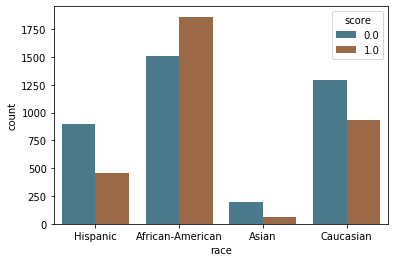

In [8]:
by_race = sns.countplot(x="race", hue="score", data=df, palette=aq_palette)

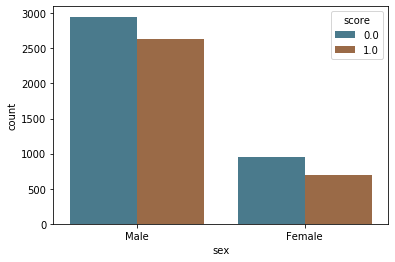

In [9]:
by_sex = sns.countplot(x="sex", hue="score", data=df, palette=aq_palette)

### Levels of recidivism

This dataset includes information about whether or not the subject recidivated, and so we can directly test the accuracy of the predictions. First, we visualize the recidivsm rates across race. 

Following ProPublica, we defined recidivism as a new arrest within two years. (If a person recidivates, `label_value` = 1). They "based this decision on Northpointe’s practitioners guide, which says that its recidivism score is meant to predict 'a new misdemeanor or felony offense within two years of the COMPAS administration date.'"

Again, the results look rather similar to the original graphs, but the key message stays the same: The graphs show the recidivism rates are higher for black defendants compared to white defendants. 

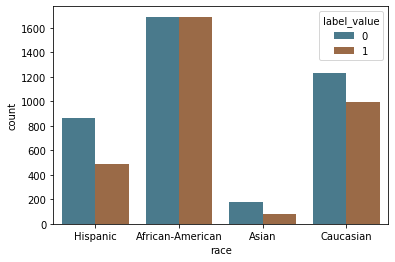

In [10]:
label_by_race = sns.countplot(x="race", hue="label_value", data=df, palette=aq_palette)

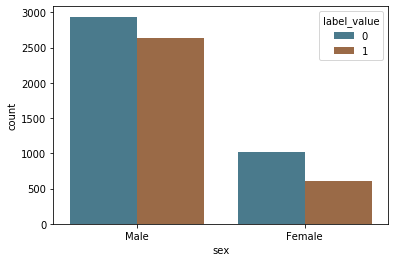

In [11]:
label_by_sex = sns.countplot(x="sex", hue="label_value", data=df, palette=aq_palette)

[Back to Top](#top_cell)

## Analysis

Do the patterns found in the exploration reflect bias or not. 

<a id='existing_biases'></a>
### Biases

We will first be looking at the confusion matrix of each subgroup, calculating commonly used metrics such as false positive rate and false omission rate, as well as counts by group and group prevelance among the sample population. 

The results we get using NamSor's predictions are a bit different at times than the results we can get from the original data. For instance the tpr for Hispanics is 0.44 originally and 0.52 here. However, for now it appears that the bigger picture is still similar. African-Americans have a fpr of 42%, while Caucasians have a fpr of only 28%. This means that African-American people are far more likely to be falsely labeled as high-risk than white people. The distance between fpr for African-Americans and Caucasians appears to be smaller than for the original data. The distance between False ommision rates (`for`) seem to be even smaller here than in the original data set and the distance between false discovery rates (`fdr`) is even 0.

In [12]:
g = Group()
xtab, _ = g.get_crosstabs(df)
absolute_metrics = g.list_absolute_metrics(xtab)

model_id, score_thresholds 0 {'rank_abs': [3317]}


In [13]:
# Calculated counts across sample population groups
xtab[[col for col in xtab.columns if col not in absolute_metrics]]

,model_id,score_threshold,k,attribute_name,attribute_value,pp,pn,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities
0,0,binary 0/1,3317,race,African-American,1863,1513,702,525,988,1161,1686,1690,3376,7214
1,0,binary 0/1,3317,race,Asian,64,192,25,41,151,39,80,176,256,7214
2,0,binary 0/1,3317,race,Caucasian,932,1297,351,414,883,581,995,1234,2229,7214
3,0,binary 0/1,3317,race,Hispanic,458,895,204,236,659,254,490,863,1353,7214
4,0,binary 0/1,3317,sex,Female,689,946,320,241,705,369,610,1025,1635,7214
5,0,binary 0/1,3317,sex,Male,2628,2951,962,975,1976,1666,2641,2938,5579,7214


In [14]:
# Calculated rates for each sample population group
xtab[['attribute_name', 'attribute_value'] + absolute_metrics].round(2)

,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,race,African-American,0.69,0.58,0.35,0.38,0.42,0.31,0.65,0.62,0.56,0.55,0.50
1,race,Asian,0.49,0.86,0.21,0.39,0.14,0.51,0.79,0.61,0.02,0.25,0.31
2,race,Caucasian,0.58,0.72,0.32,0.38,0.28,0.42,0.68,0.62,0.28,0.42,0.45
3,race,Hispanic,0.52,0.76,0.26,0.45,0.24,0.48,0.74,0.55,0.14,0.34,0.36
4,sex,Female,0.60,0.69,0.25,0.46,0.31,0.40,0.75,0.54,0.21,0.42,0.37
5,sex,Male,0.63,0.67,0.33,0.37,0.33,0.37,0.67,0.63,0.79,0.47,0.47


[Back to Top](#top_cell)
<a id='bias_viz'></a>

#### Visualization

The results we obtain when looking at group metrics accross all groups are similar to the original results:

FNR: The groups COMPAS incorrectly predicts as 'low' or 'medium' risk most often are Male and African American (see the absolute numbers). From the darker coloring, we can also tell that these are the two largest populations in the data set.

PPR: We can see that the largest 'race' group, African Americans, are still predicted positive more often than any other race group (0.56) even though this is less than in the original data set. 

FPR: African Americans are still more likely to be incorrectly classified as 'high' risk (0.42, a little less than in the original data set) than incorrectly classified as 'low' or 'medium' risk. 

We can also see that the model is equally likely to incorrectly predict a woman as 'high' risk as it is for a man (false positive rate `FPR` of 0.32 for both Male and Female).

In [15]:
aqp = Plot()

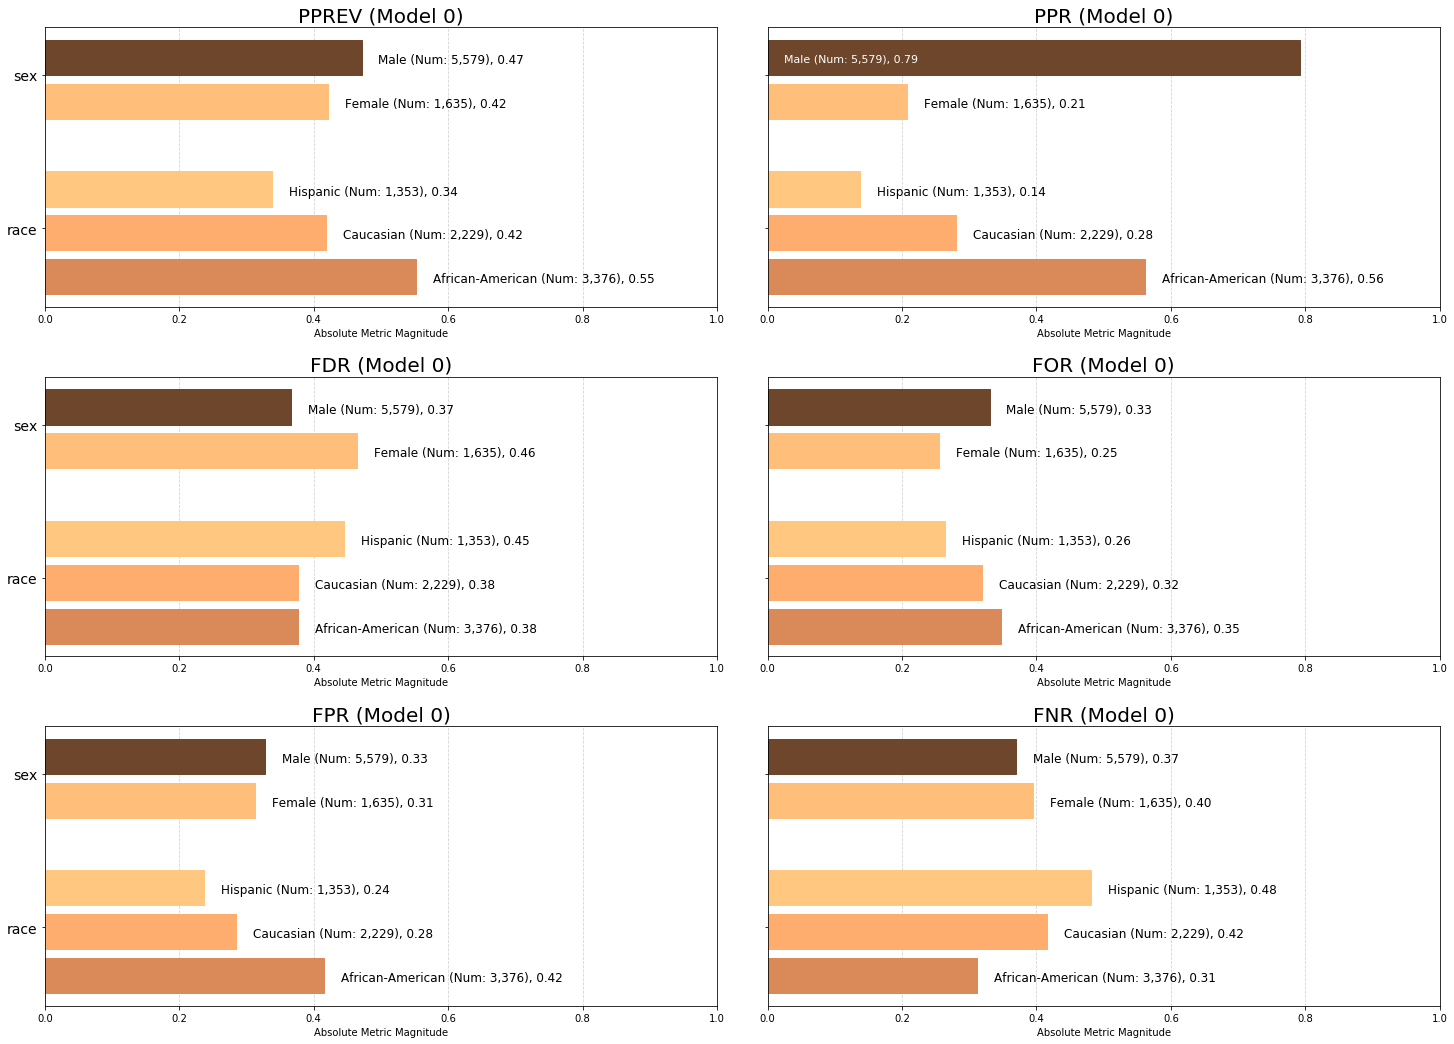

<Figure size 432x288 with 0 Axes>

In [16]:
# group metrics accross all groups
a = aqp.plot_group_metric_all(xtab, ncols=2, min_group_size=0.05)

[Back to Top](#top_cell)
<a id='disparities'></a>

### Disparities between Groups

We can observe different results for the NamSor predictions than for the original data.

There are almost as many negative predictions for African Americans before but considerably less positive predictions (1863 compared to 2174). For Caucasians the opposite is true: There are now a little more positive predictions and considerably less negative predictions. For Hispanics, there are now way more positive and negative predictions.

While there are almost as many incorrect negative predictions and correct negative predictions, the amount of false positives and true negatives is now smaller for African Americans. For Caucasians, the amounts of false negatives, false positives and true positives remained pretty much the same but the amount of true negatives decreased. For Hispanics there are now many more false positives, true positives, false negatives and true negatives with their values roughly doubling. 

When looking at the prevalence we see that these values stayed roughly the same, but with now a little higher prevalence for Caucasians (0.45 compared to 0.39 before). 

Let's have a look at changes in disparities resulting from these changes of metric values.

From the fpr we still get the result that African Americans are falsely assigned a high or medium risk score more often than Caucasians, but the rate is now 1.4 instead of 1.9. The fdr disparity values changed very little.

TODO: Take the important parts and put them into understandable words

About true positive rate disparities:
* The tpr disparity is now smaller and there is no significant disparity for African American compared to Caucasians.
* The tpr disparity is now considerably different for Asians (0.83 compared to 1.28 originally) and there is a significant disparity. This is because NamSor classifies more people as Asian, so the overall group of estimated Asians is bigger in this data set (256 compared to 32). 
* The tpr disparity is pretty similar for Hispanics in the NamSor annotated data set and in the original data set, but here the disparity is found to be significant. Again, more people are labelled as Hispanic here than in the original data set (1353 compared to 637 previousely).

About true negative rate disparities:
* Here the results are very similar except that the tnr disparity between Hispanics and Caucasians is significant in this data set. 

About precision disparities:
* The precision disparities here are considerably different from the origin data set, being below 1 here and above 1 in the original data set. Either way, no precision disparity is significant except for the one between Hispanics and Caucasians (in the original data set, no precision disparity was significant at all).

About predicted prevalence disparities:
* The disparity values are fairly similar, but now the disparity for Asians compared to Caucasians is significant.

About positive predictive disparities:
* ppr disparity values are rather different. Between African-Americans and Caucasians the disparity was 2.55 originally and is 2 here. Between Hispanics and Caucasians the disparity was 0.22 and is here 0.5. The only change in significance that can be observed is for Asians, where the disparity value is 0.07 here and 0.01 in the original data set.

About negative predictive value disparities:
* Even though we have similar disparity values except for Hispanics compared to Caucasians where the value was slightly below 1 and is now slightly above 1, we get inversed significance here: The disparity between African-Americans is not significant anymore, but the disparity values for Asians and Hispanics are.

About false omission rate disparities:
* The for disparity between African-Americans and Caucasians is not significant anymore, it is smaller here.
* The for disparity between Asians and Caucasians is now significant and it bigger here.
* The for disparity between Hispanics and Caucasians is also significant here and now smaller than 1, while it was slightly above 1 before.

About false negative rate disparities:
* The fnr disparity for African-Americans is not significant anymore
* the fnr disparity for Asians is significant now and bigger than one (1.23) while it was below 1 (0.7) before
* the fnr disparity for Hispanics is now significant while the value is still similar.

In [17]:
b = Bias()

In [18]:
bdf = b.get_disparity_predefined_groups(xtab, original_df=df, 
                                        ref_groups_dict={'race':'Caucasian', 'sex':'Male'}, 
                                        alpha=0.05, check_significance=True, 
                                        mask_significance=True)
bdf.style

get_disparity_predefined_group()


,model_id,score_threshold,k,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,pp,pn,ppr,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev,label_value_significance,score_significance,fdr_disparity,fdr_ref_group_value,fdr_significance,fnr_disparity,fnr_ref_group_value,fnr_significance,for_disparity,for_ref_group_value,for_significance,fpr_disparity,fpr_ref_group_value,fpr_significance,npv_disparity,npv_ref_group_value,npv_significance,ppr_disparity,ppr_ref_group_value,ppr_significance,pprev_disparity,pprev_ref_group_value,pprev_significance,precision_disparity,precision_ref_group_value,precision_significance,tnr_disparity,tnr_ref_group_value,tnr_significance,tpr_disparity,tpr_ref_group_value,tpr_significance
0,0,binary 0/1,3317,race,African-American,0.688612,0.584615,0.346993,0.376812,0.415385,0.311388,0.653007,0.623188,1863,1513,0.561652,0.551836,702,525,988,1161,1686,1690,3376,7214,0.499408,True,True,1.00054,Caucasian,False,0.748384,Caucasian,False,1.08708,Caucasian,False,1.46036,Caucasian,False,0.959174,Caucasian,False,1.99893,Caucasian,True,1.31979,Caucasian,True,0.999676,Caucasian,False,0.817005,Caucasian,False,1.17929,Caucasian,False
1,0,binary 0/1,3317,race,Asian,0.4875,0.857955,0.213542,0.390625,0.142045,0.5125,0.786458,0.609375,64,192,0.0192945,0.25,25,41,151,39,80,176,256,7214,0.3125,True,True,1.03722,Caucasian,False,1.23173,Caucasian,True,0.668994,Caucasian,True,0.499385,Caucasian,False,1.15519,Caucasian,True,0.0686695,Caucasian,True,0.597908,Caucasian,True,0.977517,Caucasian,False,1.199,Caucasian,False,0.834875,Caucasian,True
2,0,binary 0/1,3317,race,Caucasian,0.58392,0.715559,0.319198,0.376609,0.284441,0.41608,0.680802,0.623391,932,1297,0.280977,0.418125,351,414,883,581,995,1234,2229,7214,0.446389,False,False,1,Caucasian,False,1,Caucasian,False,1,Caucasian,False,1,Caucasian,False,1,Caucasian,False,1,Caucasian,False,1,Caucasian,False,1,Caucasian,False,1,Caucasian,False,1,Caucasian,False
3,0,binary 0/1,3317,race,Hispanic,0.518367,0.763615,0.263687,0.445415,0.236385,0.481633,0.736313,0.554585,458,895,0.138077,0.338507,204,236,659,254,490,863,1353,7214,0.362158,True,True,1.1827,Caucasian,True,1.15755,Caucasian,True,0.826092,Caucasian,True,0.83105,Caucasian,True,1.08154,Caucasian,True,0.491416,Caucasian,True,0.809584,Caucasian,True,0.889627,Caucasian,True,1.06716,Caucasian,True,0.887738,Caucasian,True
4,0,binary 0/1,3317,sex,Female,0.604918,0.687805,0.254757,0.464441,0.312195,0.395082,0.745243,0.535559,689,946,0.207718,0.421407,320,241,705,369,610,1025,1635,7214,0.373089,True,True,1.26876,Male,True,1.07017,Male,True,0.771064,Male,True,0.953461,Male,True,1.11296,Male,True,0.262177,Male,True,0.894607,Male,True,0.844807,Male,True,1.02266,Male,True,0.958937,Male,True
5,0,binary 0/1,3317,sex,Male,0.630822,0.672566,0.330396,0.366058,0.327434,0.369178,0.669604,0.633942,2628,2951,0.792282,0.471052,962,975,1976,1666,2641,2938,5579,7214,0.473382,False,False,1,Male,False,1,Male,False,1,Male,False,1,Male,False,1,Male,False,1,Male,False,1,Male,False,1,Male,False,1,Male,False,1,Male,False


[Back to Top](#top_cell)
<a id='disparity_viz'></a>

#### Visualization


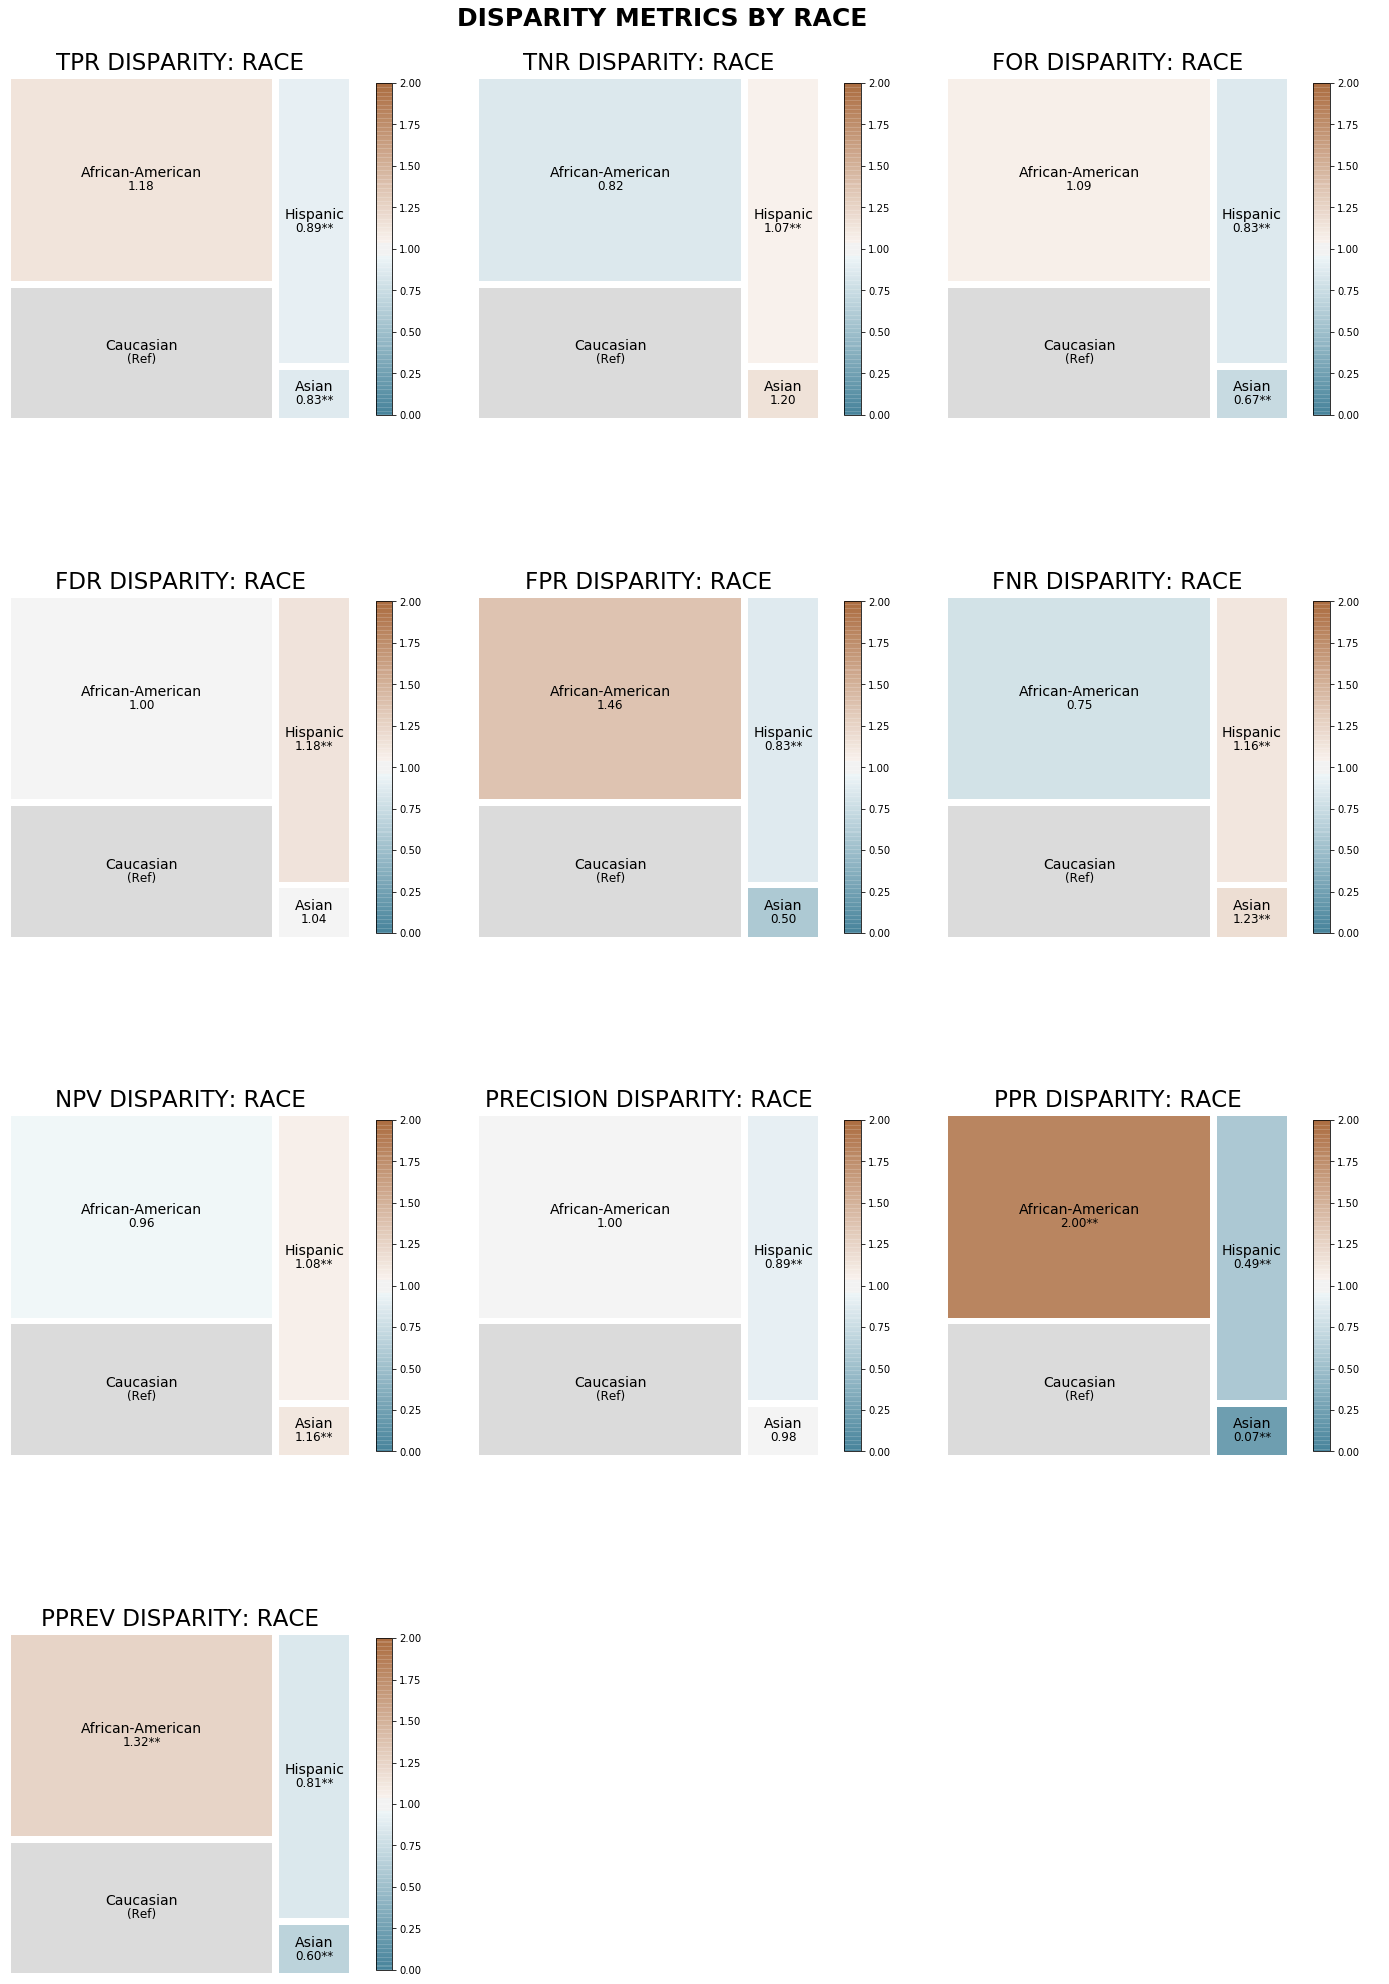

In [19]:
plots_race = aqp.plot_disparity_all(bdf, attributes=['race'], metrics = 'all', significance_alpha=0.05)

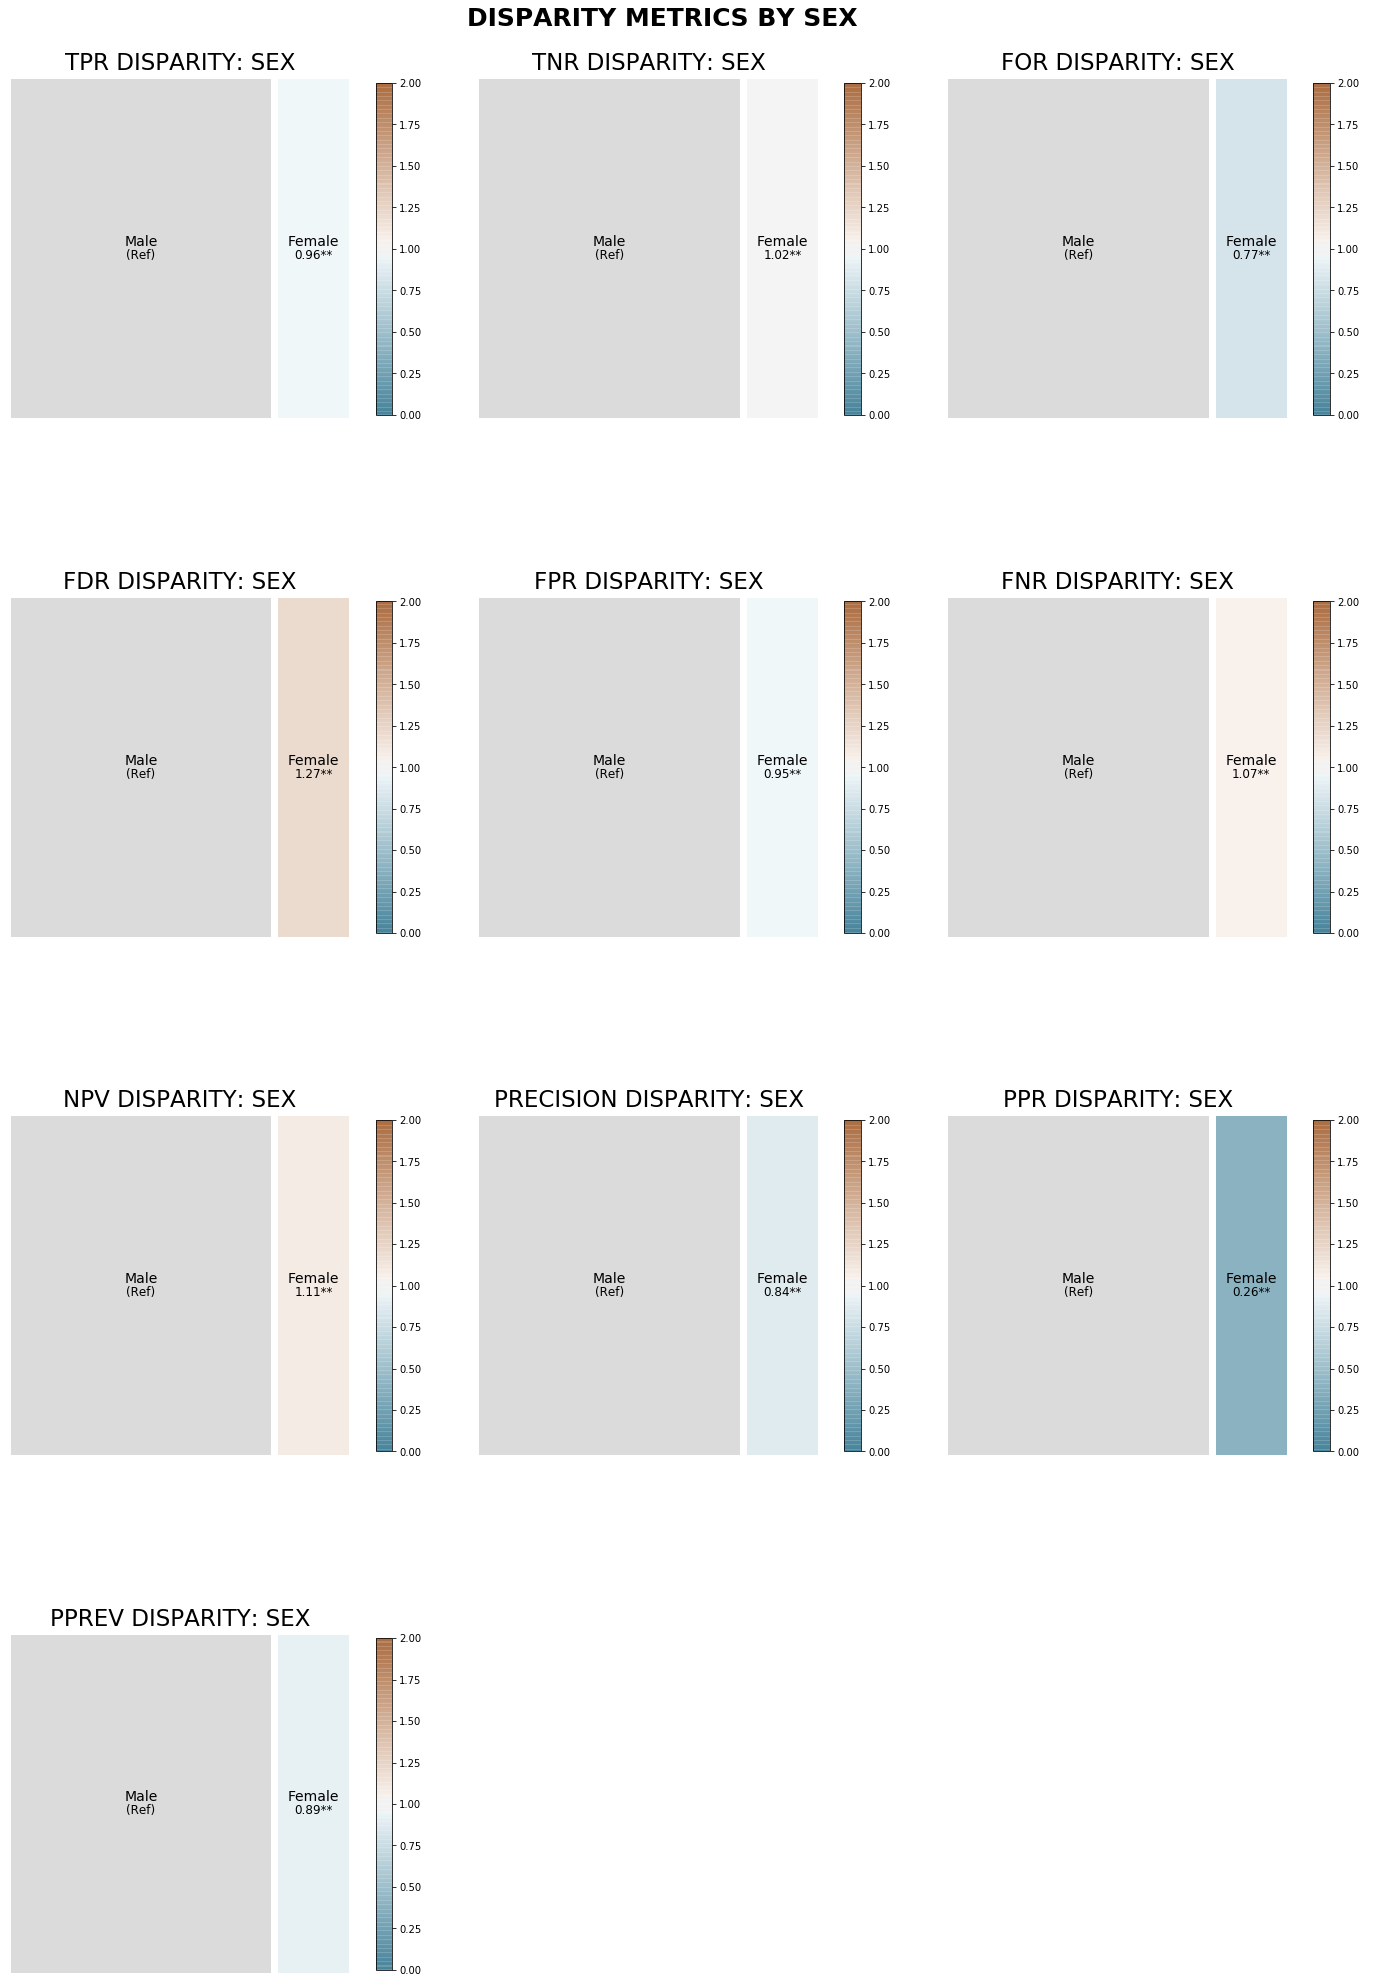

In [20]:
plots_sex = aqp.plot_disparity_all(bdf, attributes=['sex'], metrics = 'all', significance_alpha=0.05)

### Fairness Assessment

In this case, our base groups are Caucasian for race and Male for gender. With NamSor annotated data we still get the same result for subervised fairness: Relative to the base groups, the COMPAS predictions only provide supervised fairness to one group, Hispanic.

Like in the original data, the African-American false omission and false discovery are within the bounds of fairness. This result is expected because COMPAS is calibrated. (Given calibration, it is surprising that Asian and Native American rates are so low. This may be a matter of having few observations for these groups.)

African-Americans are about 1.5 times as likely to have false positives and 40 percent less likely to false negatives. In real terms, 41.5% (a little lower than originally) of African-Americans who did not recidivate were marked high or medium risk (with potential for associated penalties), compared with 28.4% (a little higher than originally) of Caucasian non-reoffenders. This is unfair and is marked False below.

Overall, we get the same results for fairness, except:
* There is now FDR Parity for race
* There is now FPR Parity for sex
* There is now TPR Parity for race
* There is now TNR Parity for race
* There is now Precision Parity for race

In [21]:
f = Fairness()
fdf = f.get_group_value_fairness(bdf)

In [22]:
parity_detrminations = f.list_parities(fdf)

In [23]:
fdf[['attribute_name', 'attribute_value'] + absolute_metrics + b.list_disparities(fdf) + parity_detrminations].style

,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev,fdr_disparity,fnr_disparity,for_disparity,fpr_disparity,npv_disparity,ppr_disparity,pprev_disparity,precision_disparity,tnr_disparity,tpr_disparity,FNR Parity,TPR Parity,Impact Parity,FDR Parity,Supervised Fairness,Statistical Parity,Unsupervised Fairness,TNR Parity,FOR Parity,TypeII Parity,Equalized Odds,NPV Parity,TypeI Parity,FPR Parity,Precision Parity
0,race,African-American,0.688612,0.584615,0.346993,0.376812,0.415385,0.311388,0.653007,0.623188,0.561652,0.551836,0.499408,1.00054,0.748384,1.08708,1.46036,0.959174,1.99893,1.31979,0.999676,0.817005,1.17929,False,True,False,True,False,False,False,True,True,False,False,True,False,False,True
1,race,Asian,0.4875,0.857955,0.213542,0.390625,0.142045,0.5125,0.786458,0.609375,0.0192945,0.25,0.3125,1.03722,1.23173,0.668994,0.499385,1.15519,0.0686695,0.597908,0.977517,1.199,0.834875,True,True,False,True,False,False,False,True,False,False,False,True,False,False,True
2,race,Caucasian,0.58392,0.715559,0.319198,0.376609,0.284441,0.41608,0.680802,0.623391,0.280977,0.418125,0.446389,1,1,1,1,1,1,1,1,1,1,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
3,race,Hispanic,0.518367,0.763615,0.263687,0.445415,0.236385,0.481633,0.736313,0.554585,0.138077,0.338507,0.362158,1.1827,1.15755,0.826092,0.83105,1.08154,0.491416,0.809584,0.889627,1.06716,0.887738,True,True,True,True,True,False,False,True,True,True,True,True,True,True,True
4,sex,Female,0.604918,0.687805,0.254757,0.464441,0.312195,0.395082,0.745243,0.535559,0.207718,0.421407,0.373089,1.26876,1.07017,0.771064,0.953461,1.11296,0.262177,0.894607,0.844807,1.02266,0.958937,True,True,True,False,False,False,False,True,False,False,True,True,False,True,True
5,sex,Male,0.630822,0.672566,0.330396,0.366058,0.327434,0.369178,0.669604,0.633942,0.792282,0.471052,0.473382,1,1,1,1,1,1,1,1,1,1,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True


In [24]:
gaf = f.get_group_attribute_fairness(fdf)
gaf

,model_id,score_threshold,attribute_name,Statistical Parity,Impact Parity,FDR Parity,FPR Parity,FOR Parity,FNR Parity,TPR Parity,TNR Parity,NPV Parity,Precision Parity,TypeI Parity,TypeII Parity,Equalized Odds,Unsupervised Fairness,Supervised Fairness
0,0,binary 0/1,race,False,False,True,False,False,False,True,True,True,True,False,False,False,False,False
1,0,binary 0/1,sex,False,True,False,True,False,True,True,True,True,True,False,False,True,False,False


In [25]:
gof = f.get_overall_fairness(fdf)
gof

{'Unsupervised Fairness': False,
 'Supervised Fairness': False,
 'Overall Fairness': False}

#### Visualization
We can see that negative predictive parity status is 'True' for all population groups, like with the original data, but we additionally see TPR, TNR and Precision being fair, and that unfairness is smaller for the other values as well.

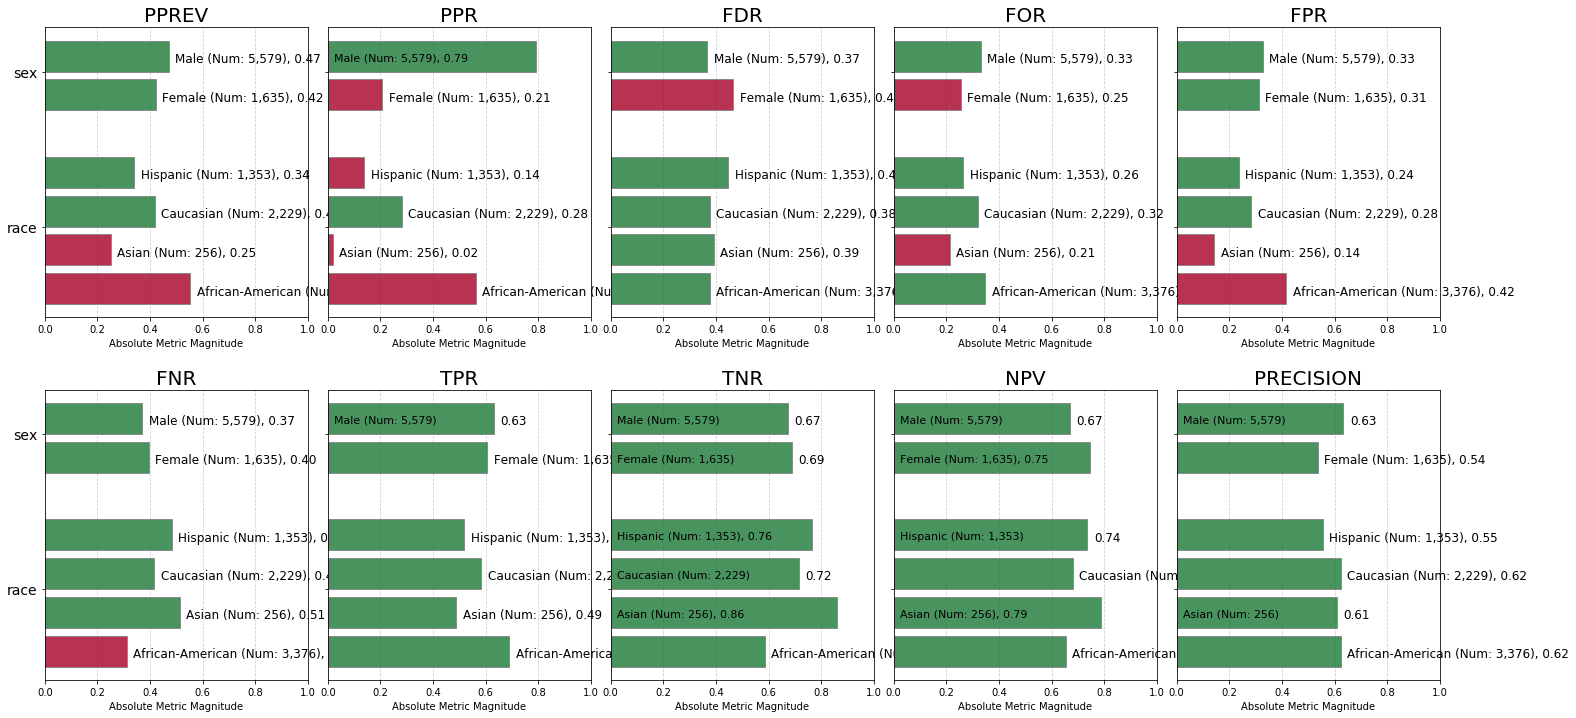

<Figure size 432x288 with 0 Axes>

In [26]:
fg = aqp.plot_fairness_group_all(fdf, ncols=5, metrics = "all")

[Back to Top](#top_cell)